In [18]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gymnasium
import matplotlib.pyplot as plt

In [19]:
NUM_RUNS = 10

num_neurons_in_hidden = 128 # A = number of neurons in each hidden layer
num_hidden_layers = 2 # B = number of hidden layers
learning_rate = 0.00025 # C = learning rate
replay_buff_size = 10000 # D = size of the replay buffer
number_of_episodes = 300 # E = number of episodes
epsilon = -1.0 # F = epsilon (I set it to -1.0 to use epsilon greedy strategy)
G = 1 # reward scaling factor
batch_size = 64 # H = batch size
relax_period = 100 # I = relaxtion period

In [20]:
def run_experiment(num_runs=NUM_RUNS, 
                   num_neurons_in_hidden=num_neurons_in_hidden, 
                   num_hidden_layers=num_hidden_layers, 
                   learning_rate=learning_rate, 
                   replay_buff_size=replay_buff_size, 
                   number_of_episodes=number_of_episodes, 
                   epsilon=epsilon, 
                   G=G, 
                   batch_size=batch_size, 
                   relax_period=relax_period):
    runs_results = []
    env = gymnasium.make('CartPole-v1')
    for run in range(num_runs):
        print(f"Starting run {run+1} of {num_runs}")
        layers = [4] + [num_neurons_in_hidden]*num_hidden_layers + [2]  
        policy_net = DQN(layers)
        target_net = DQN(layers)
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.AdamW(policy_net.parameters(), lr=learning_rate)
        memory = ReplayBuffer(replay_buff_size)

        steps_done = 0

        episode_durations = []

        for i_episode in range(number_of_episodes):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", number_of_episodes)

            observation, info = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0
            while not (done or terminated):
                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state, i_episode)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])/G
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
                steps_done += 1
                # Update the target network, copying all weights and biases in DQN
                if steps_done % relax_period == 0: 
                    update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results, policy_net

In [21]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
import os


def plot_learning_curve(runs_results, name ="", output_dir=""):
    os.makedirs(output_dir, exist_ok=True)
    num_episodes = len(runs_results[0])
 
    results = torch.tensor(runs_results)
    means = results.float().mean(0)
    stds = results.float().std(0)

    plt.plot(torch.arange(num_episodes), means)
    plt.ylabel("Return")
    plt.xlabel("Episode Number")
    plt.fill_between(np.arange(num_episodes), means, means+stds, alpha=0.3, color='b')
    plt.fill_between(np.arange(num_episodes), means, means-stds, alpha=0.3, color='b')
    plt.title(f"Learning Curve - average return over {len(runs_results)} runs")
    plt.legend(["mean", "std"])
    plt.savefig(os.path.join(output_dir, f"{name}.png"))
    plt.show()


Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

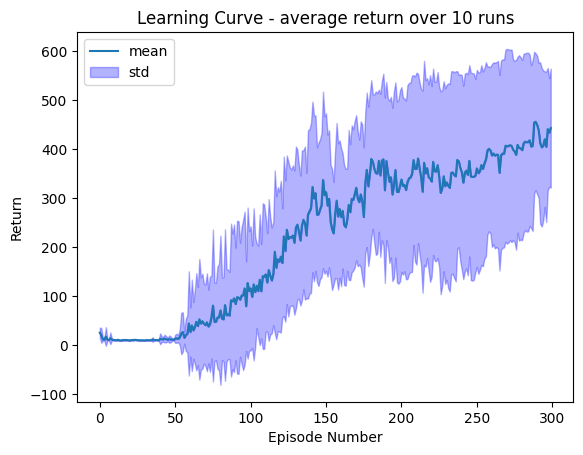

In [22]:

runs_results, _ = run_experiment()
plot_learning_curve(runs_results,
                output_dir="outputs",
                name=f"final_learning_curve")

In [26]:
run_results, policy_net = run_experiment(num_runs=1)

Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete


C:\Users\Alona Rimon\AppData\Local\Temp\ipykernel_18104\13493224.py:12: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  stds = results.float().std(0)


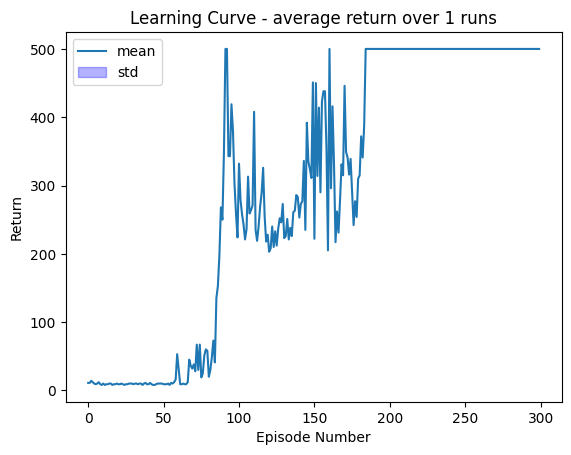

In [27]:
plot_learning_curve(run_results, output_dir="outputs", name="single_run")

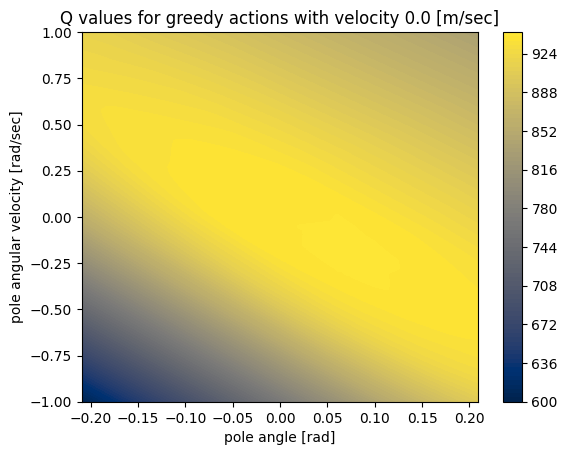

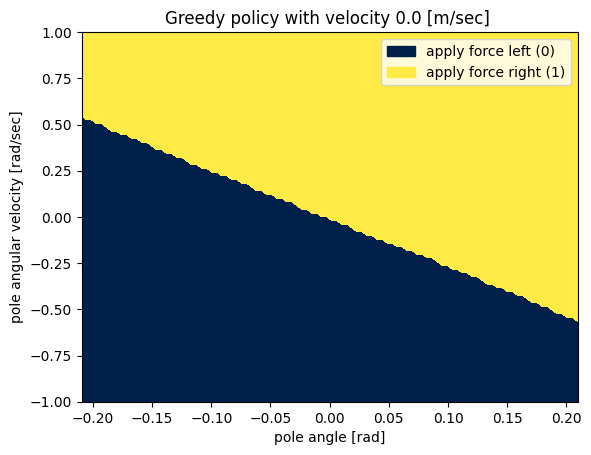

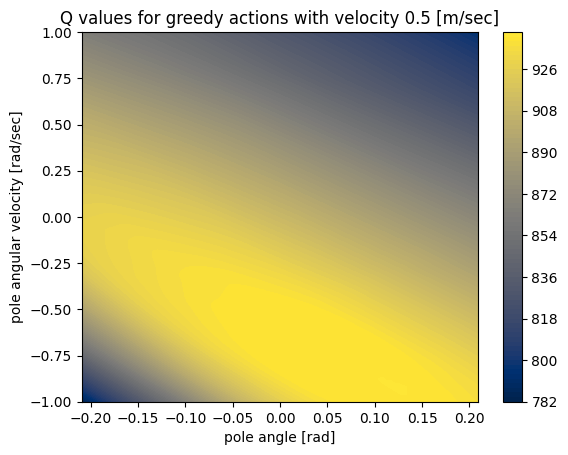

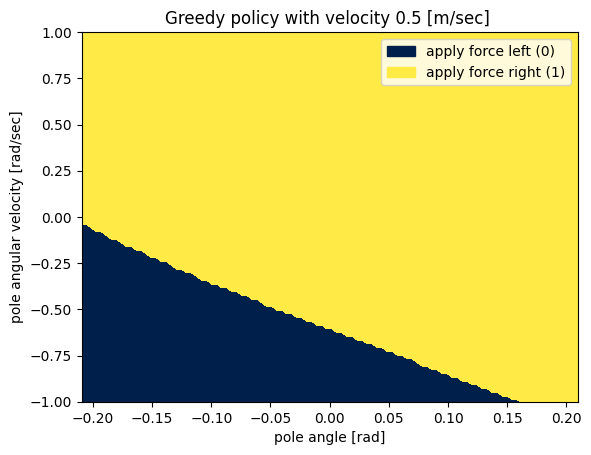

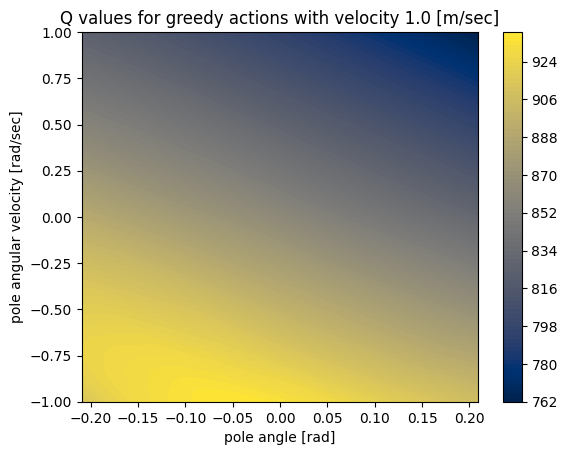

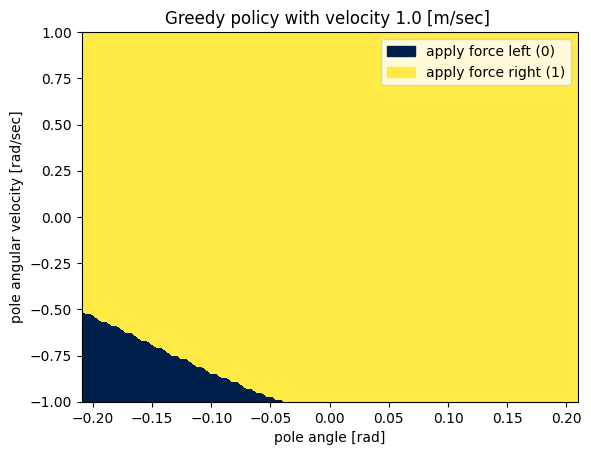

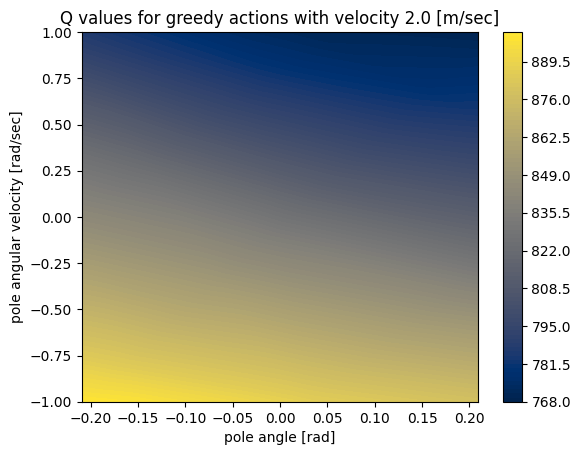

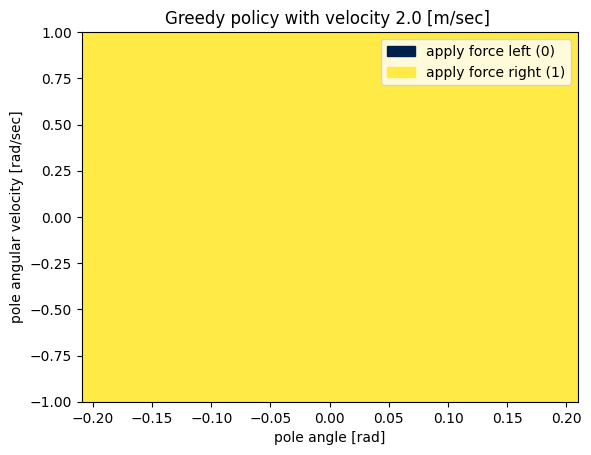

In [ ]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"


# All visualisations provided here are placeholders and you can freely modify these plots and code

# Make sure to include appropriate labels and/or legends when presenting your plot

import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

q = True    # whether to visualize the Q values
policy_visualization = True # whether to visualize the policy

angle_range = .2095 # you may modify this range
omega_range = 2     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)


cart_velocities = [0., 0.5, 1., 2.]
for v, velicity in enumerate(cart_velocities):
    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., velicity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        plt.xlabel("pole angle [rad]")
        plt.ylabel("pole angular velocity [rad/sec]")
        plt.title(f"Q values for greedy actions with velocity {velicity} [m/sec]") 
        plt.colorbar()
        plt.show()
        plt.savefig(f"outputs/q_values__angle_omega_v_{v}.png")
        plt.close()
    if policy_visualization:
        plt.contourf(angles, omegas, policy_array.T, levels=[-0.5, 0.5, 1.5], cmap=mcolors.ListedColormap(['#00204C', '#FFEA46']))
        plt.xlabel("pole angle [rad]")
        plt.ylabel("pole angular velocity [rad/sec]")
        plt.title(f"Greedy policy with velocity {velicity} [m/sec] ")
        plt.savefig(f"outputs/policy__angle_omega_v_{v}.png")
        left_patch = mpatches.Patch(color='#00204C', label="apply force left (0)")
        right_patch = mpatches.Patch(color='#FFEA46', label="apply force right (1)")
        plt.legend(handles=[left_patch, right_patch])
        plt.show()
        plt.close()